###Counting cars and detecting moving objects

Imports:

In [ ]:
import os
from google.colab import drive
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

Constants:

In [ ]:
FILENAME = 'parking_video_Trim.mp4' # input video
OUTPUT_FILENAME = 'car_count.mp4' # output video
DIRECTORY_NAME = 'video_frames' # path to save the frames - MUST CREATE FOLDER BEFORE RUNNING!
OUTPUT_DIRECTORY_NAME = 'output_frames'

# images coordinates where we set the bar
X1 = 980
X2 = 1020
Y1 = Y2 = 640
START_POINT = (X1, Y1)
END_POINT = (X2, Y2)
OFFSET = 100

COLOR = (0, 255, 0) # Green (RGB) color for the bar to appear on the images
THICKNESS = 5 # Line thickness, 5px

***

In [ ]:
# Connect with local files on Google Drive

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Image_processing/Ofir/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_all_frames(filename):
    '''
    Save all frames from video as images
    '''
    vidcap = cv2.VideoCapture(filename)
    success,image = vidcap.read()
    count = 0
    
    while success:
        greyscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting the images into greyscale
        cv2.imwrite(f'{DIRECTORY_NAME}/frame%d.jpg' % count, greyscaled_image) # saving frame as JPEG file
        success,image = vidcap.read()
        # print(f'Read frame number {count}: {success}')
        count += 1

In [ ]:
# Comment-out when no frames exist (on initial run)
save_all_frames(FILENAME)

In [ ]:
# get file names of the frames
col_frames = os.listdir(f'{DIRECTORY_NAME}/')

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
col_images=[]

for i in col_frames:
    # read the frames
    img = cv2.imread(f'{DIRECTORY_NAME}/{i}')
    # append the frames to the list
    col_images.append(img)

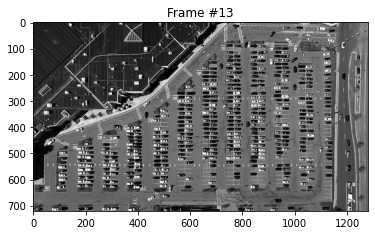

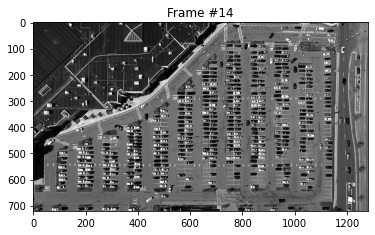

In [ ]:
def plot_two_consecutive_frames(i = 1):
    '''Display two consecutive frames'''

    for frame in [i, i+1]:
        plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
        plt.title(f'Frame #{str(frame)}')
        plt.show()


index = 13 # plot frames 13 & 14 (13 just for the example)
plot_two_consecutive_frames(index)

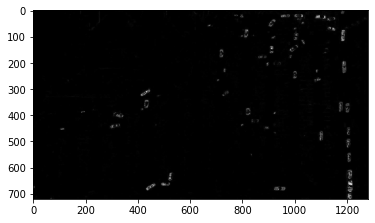

In [ ]:
def get_difference_between_frames(i = 1, show=False):
    '''Taking the difference of the pixel values of two consecutive frames will help us observe the moving objects'''

    # convert the frames to grayscale
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

    # plot the image after frame differencing
    diff_image = cv2.absdiff(grayB, grayA)

    if show:
        plt.imshow(diff_image, cmap = 'gray')
        plt.show()

    return diff_image


diff_image = get_difference_between_frames(index, True)


# Now we can clearly see the moving objects in the given index consecutive frames. Everything else that was not moving has been subtracted out.

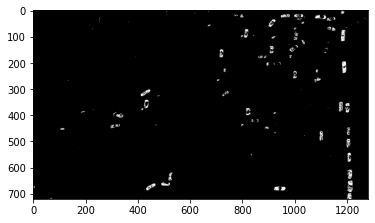

In [ ]:
def perform_image_thresholding(diff_image, show=False):
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

    if show:
        # plot image after thresholding
        plt.imshow(thresh, cmap = 'gray')
        plt.show()

    return thresh


thresh = perform_image_thresholding(diff_image, True)


# After applying thresholding to the above image, most of the noise (undesired white regions) is gone:

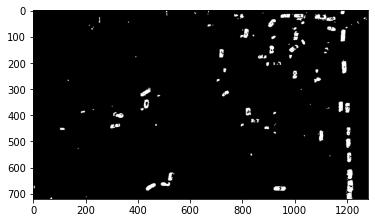

In [ ]:
def apply_image_dilation(thresh, show=False):
    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)

    if show:
        # plot dilated image
        plt.imshow(dilated, cmap = 'gray')
        plt.show()

    return dilated



dilated = apply_image_dilation(thresh, True)


# Since the highlighted regions are a bit fragmented, we dilate the image as we did in HW1 as one of the steps of the Canny Edge Detector algorithm:

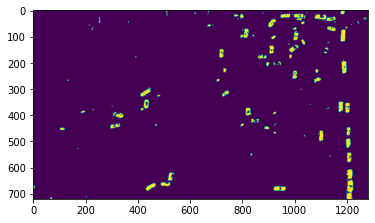

In [ ]:
# plot vehicle detection zone (we are not going to use the entire frame to detect moving vehicles. We will first select a zone, and if a vehicle moves into that zone, then only it will be detected)
plt.imshow(dilated)
cv2.line(dilated, START_POINT, END_POINT, COLOR)
plt.show()

In [ ]:
# find contours
# The code below finds all the contours in the entire image and keeps them in the variable 'contours'.
contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

valid_cntrs = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)

    # Since we want to find only the contours that are present in the detection zone, we will apply a couple of checks on the discovered contours:
    if (x >= X1) & (x <= X2) & (y <= Y2 + OFFSET) & (y >= Y1 - OFFSET) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

0

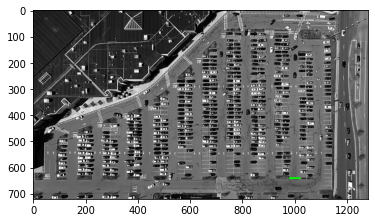

In [ ]:
# plot the contours along with the original frame (may not see anything if no movement in area of current frame)

dmy = col_images[index].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, START_POINT, END_POINT, COLOR, THICKNESS) 
plt.imshow(dmy)
plt.show()



# Contours of only those vehicles that are inside the detection zone are visible. This is how we will detect vehicles in all the frames.

***
###Combining everything:<br>
Here we apply the same image transformations and pre-processing operations from above on all the frames and find the desired contours.

As a reminder, the steps are:
1. Apply frame differencing on every pair of consecutive frames
2. Apply image thresholding on the output image of the previous step
3. Perform image dilation on the output image of the previous step
4. Find contours in the output image of the previous step
5. Draw contours appearing in the detection zone
6. Save frames along with the final contours as a video


In [ ]:
# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = OUTPUT_DIRECTORY_NAME

for i in range(len(col_images)-1):
    # frame differencing
    diff_image = get_difference_between_frames(i)
    
    # image thresholding
    thresh = perform_image_thresholding(diff_image)
    
    # image dilation
    dilated = cv2.dilate(thresh, kernel, iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []

    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)

        if (x >= X1) & (x <= X2) & (y <= Y2 + OFFSET) & (y >= Y1 - OFFSET) & (cv2.contourArea(cntr) >= 25):
            # if (y >= 700) & (cv2.contourArea(cntr) < 40):
                # break
            valid_cntrs.append(cntr)
    
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, f'vehicles detected: {str(len(valid_cntrs))}', (1000, 700), font, 0.6, (0, 180, 0), 2)

    cv2.line(dmy, START_POINT, END_POINT, COLOR) 
    cv2.imwrite(f'{pathIn}/{str(i)}.png', dmy) 

***
### Video Preparation:
Stack up the frames and create a video

In [ ]:
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

In [ ]:
files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename = f'{pathIn}/{files[i]}'
    
    #read frames
    img = cv2.imread(filename)
    # print(img)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

In [ ]:
# specify frames per second
fps = 14.0

out = cv2.VideoWriter(OUTPUT_FILENAME,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()